# Using study time and exam performance to model level of understanding

## Introduction

Teachers and professors worldwide consistently work to help teach new subjects to students. While there are many different ways to measure a student's understanding of a subject, many schools often use examinations as a test of a student's academic capabilities. However, recent studies show that other methods of testing, such as questionnaires or qualitative methods, have other benefits to offer students learning (Sundberg). With this in mind, our group looked into the User Knowledge Modelling Database published by the UC Irvine Machine Learning Repository. This dataset contains data regarding students' knowledge status about the subject of Electrical DC Machines and their relative study times, repetition times and exam scores (Kahraman et al.). The data in this dataset has already been standardized. From this, our group decided to investigate:

**Given study time and a student's exam performance, can we accurately predict their level of understanding of the goal topic?** 


## Preliminary Data Exploratory Data Analysis

In [1]:
# Loading in necessary libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(rvest)
library(stringr)
library(janitor)
options(repr.matrix.max.rows = 6)


Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

## How to Interpret Column Names

- STG (The degree of study time for goal object materials)
- SCG (The degree of repetition number of user for goal object materials)
- STR (The degree of study time of user for related objects with goal object)
- LPR (The exam performance of user for related objects with goal object)
- PEG (The exam performance of user for goal objects)
- UNS (The knowledge level of user)

In [2]:
library(readxl)
set.seed(1234)
# The dataset does not need to be split using inital_split as the dataset is already split into acceptably sized training and testing groups 
# To avoid errors when classifying later, the variable for the class very low had to be standardized to "Very_Low" for both the training and testing datasets
user_data_training <- read_excel("Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN (1).xls", sheet = 2) |> 
              select(STG:UNS) |>
             mutate(UNS = as_factor(UNS))
user_data_training

user_data_testing <- read_excel("Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN (1).xls", sheet = 3) |>
             select(STG:UNS) |>
             mutate(UNS = as_factor(UNS))
user_data_testing

New names:
• `` -> `...7`
• `` -> `...8`


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,Very_Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


New names:
• `` -> `...7`
• `` -> `...8`


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,Very_Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


In [3]:
# Summarizing the data
set.seed(1234)
user_summary <- user_data_testing |>
    group_by(UNS) |>
    summarize(count = n(), mean_STG = mean(STG), mean_SCG = mean(SCG), mean_STR = mean(STR), mean_LPR = mean(LPR), mean_PEG = mean(PEG))

user_summary

UNS,count,mean_STG,mean_SCG,mean_STR,mean_LPR,mean_PEG
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Very_Low,26,0.2161538,0.3207692,0.3426923,0.1858077,0.1003846
Low,46,0.3369565,0.2971739,0.4145652,0.3626087,0.2823913
High,39,0.3830769,0.4423077,0.5228205,0.6102564,0.8438462
Middle,34,0.3088235,0.3652941,0.4505882,0.4964706,0.5029412


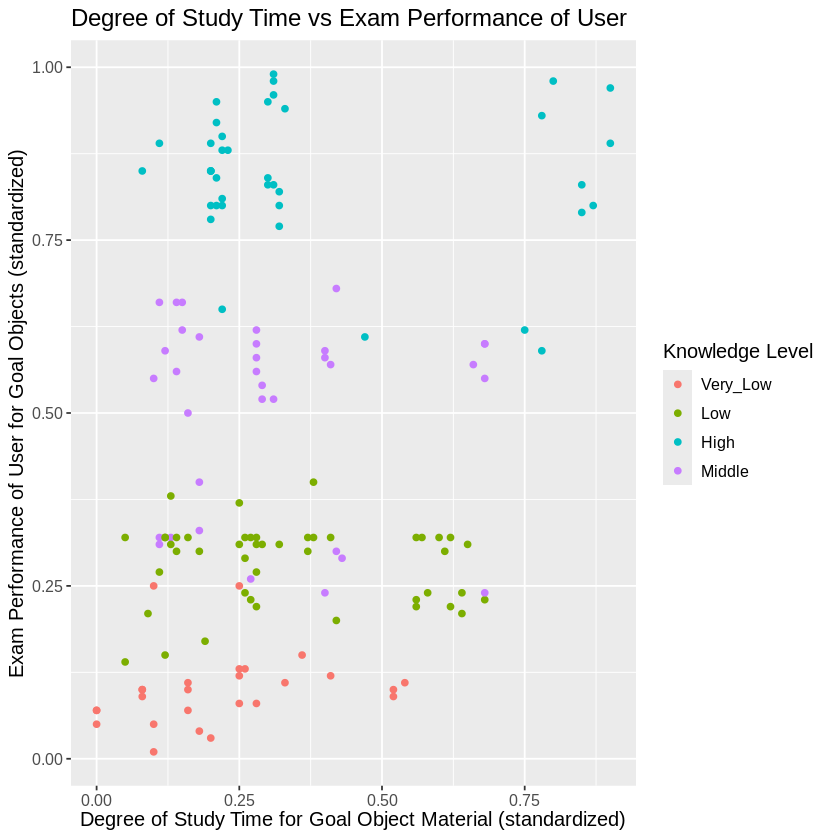

In [4]:
set.seed(1234)
user_plot_time <- ggplot(user_data_testing, aes(x = STG, y = PEG)) + 
geom_point(aes(colour = UNS)) + 
labs(x = "Degree of Study Time for Goal Object Material (standardized)", y = "Exam Performance of User for Goal Objects (standardized)", colour = "Knowledge Level") +
ggtitle("Degree of Study Time vs Exam Performance of User") +
theme(text = element_text(size = 12))
user_plot_time

## Expected outcomes and significance:
**What do you expect to find?**
- We expect to be able to use study time to accurately predict knowledge level.

**What impact could such findings have?**
- The results of this finding can prove whether the duration of study and exam scores are reliable enough to serve as factors for assessing students' mastery of knowledge. At the application level, this outcome can help schools decide which indicators to use to measure their students
  

In [5]:
# Building the knn recipe and setting up to tune the grid
set.seed(1234) 

knn_recipe <- recipe(UNS ~ STG + PEG, data = user_data_training)

vfold <- vfold_cv(user_data_training, v = 5, strata = UNS) # Has the least standard error compared to 10 folds

knn_spec <- nearest_neighbor(weight_func = "rectangular",neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
12,accuracy,multiclass,0.7946154,5,0.011252876,Preprocessor1_Model12
5,accuracy,multiclass,0.7909231,5,0.008167623,Preprocessor1_Model05
6,accuracy,multiclass,0.7909231,5,0.008167623,Preprocessor1_Model06


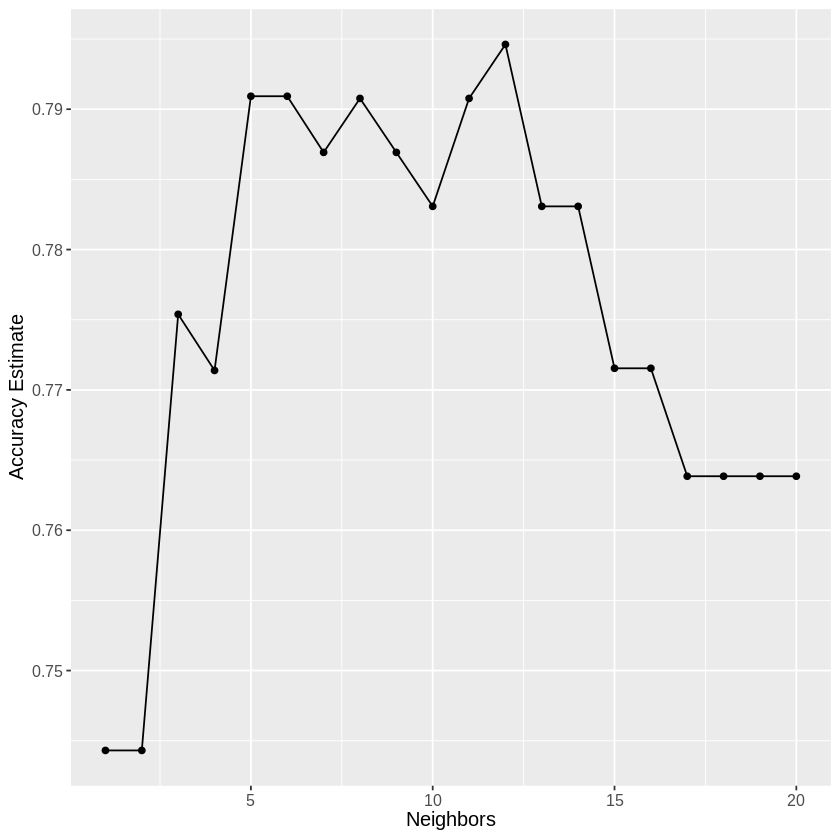

In [6]:
# Finding the most accurate K value to use
set.seed(1234) 

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

best_k <- accuracies |>
        arrange(desc(mean)) |>
        slice(1:3) 

best_k 

While the data above estimated that using K=12 would give us the highest accuracy, our earlier data visualsation shows that using 12 nearest neighbours might result in overfitting of our testing data. We decided that the ideal amount of neighbours to use would be K=6. 

In [7]:
set.seed(1234) 

# Retrain the classifier using K = 6
knn_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec_best) |>
  fit(data = user_data_testing)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1655172
Best kernel: rectangular
Best k: 6

In [8]:
set.seed(1234) 

# Predict the labels in the test set
study_predictions <- predict(knn_fit , user_data_testing) |>
       bind_cols(user_data_testing)
study_predictions

# Evaluating the classifier's performance
study_metrics <- study_predictions |>
         metrics(truth = UNS, estimate = .pred_class)|>
         filter(.metric == "accuracy")  
study_metrics

study_conf_mat <- study_predictions |> 
       conf_mat(truth = UNS, estimate = .pred_class)
study_conf_mat

.pred_class,STG,SCG,STR,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Very_Low,0.00,0.10,0.50,0.26,0.05,Very_Low
Very_Low,0.05,0.05,0.55,0.60,0.14,Low
High,0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Low,0.56,0.60,0.77,0.13,0.32,Low
Middle,0.66,0.68,0.81,0.57,0.57,Middle
Low,0.68,0.64,0.79,0.97,0.24,Middle


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8758621


          Truth
Prediction Very_Low Low High Middle
  Very_Low       24   3    0      0
  Low             2  40    0      6
  High            0   0   35      0
  Middle          0   3    4     28

We also tested K=12 and K=5 to check that the best number of neighbours was 6. When we ran the confusion matrix and checked the accuracy value for 12 and 5 we saw that the percentage accuracy for 12 neighbours was lower and that k=5 had the same values as K=6

## Methods:

Since the data we found has already gone through some basic steps, which includes being split into training data and testing data, and the data's scale and centering. Therefore, our work focused on establishing KNN classification, with the detailed steps as follows:

The first step is the selection of variables. In this project, we chose to use study time (STG) and exam performance (PEG) as variables to predict a student's understanding of knowledge (UNS). The reason is that STG and PEG are globally recognized standards for assessing student levels. It is commonly believed that students who invest a significant amount of time in their studies and achieve high scores in exams have an excellent grasp of knowledge. Therefore, we are intended to use our dataset to verify whether this intuition is really true. Furthermore, in our data, UNS is a categorical variable, while STG and PEG are numerical variables, which enables us to establish a KNN classification model.

The second step involves visualization. We created a scatter plot with STG as the x-axis and PEG as the y-axis. Additionally, we differentiated UNS with various colors. Through scatter plots, we have observed that as the values of STG and PEG vary, the points gather into different clusters. These different clusters represent different knowledge levels. This leads us to believe that a student's mastery of knowledge can be predicted by analyzing these two numerical data, STG and PEG. 

The third step is where we began to establish the KNN classification algorithm. Initially, we had to determine the most proper value of k, so we utilized tuning and cross-validation methods. Ultimately, we identified n=5 as the most suitable value for k, meaning our algorithm would predict the UNS by analyzing the UNS of the nearest 5 points to the prediction point and using the majority vote as the predicted UNS. Then we successfully established the KNN classification model by using the recipe, specification, and workflow of the tidy model respectively.

Finally, we applied this algorithm to the test data and obtained a confusion matrix. Through the confusion matrix, we determined the accuracy of our KNN classification algorithm. Out of a total of 145 data points, we correctly predicted the UNS for 24 + 40 + 35 + 28 = 127 entries. This amounts to an accuracy rate of approximately 87.6%.



## Results and Discussion: 

We had expected a higher accuracy when predicting for UNS. We believed that exam performance and study time would be the greatest indicators of knowledge level however other variables could potentially yield a higher accuracy. That being said 87.6% is a fairly reliable success rate for our model and demonstrates the relationship between exam performance, study time, and knowledge of the topic

The prediction accuracy of 87.6% can be sufficient to give instructors a general understanding of each student's level of understanding. However, since our model makes an incorrect estimation for every eight people on average, we recommend that it should only be used in ordinary situations. For example, this model is suitable for use in most schools, but it is not recommended for critically important scenarios, such as astronaut selection (where more indicators are needed).

Overall, by studying the duration of study time and exam scores, one can generally judge a student's grasp of knowledge. However, it is not a perfect indicator. We believe that assessing a student's mastery of knowledge requires many other indicators, which may be determined by different subjects or possibly influenced by lurking variables.

**What future questions could this lead to?**
-  Future studies into this topic could include:
    - What is/are the best predictors of knowledge level?
    - What other factors affect the amount of study time required to get a good mark?
    - Why is study time after a certain period ineffective?
    - How do students perform similarily on exams despite large differences in study time?


## Bibliography
Dataset link: https://archive.ics.uci.edu/dataset/257/user+knowledge+modeling

Kahraman, H. Tolga, et al. “The Development of Intuitive Knowledge Classifier and the Modeling of Domain Dependent Data.” Knowledge-Based Systems, vol. 37, Jan. 2013, pp. 283–295, https://doi.org/10.1016/j.knosys.2012.08.009.

Sundberg, Marshall D. “Assessing Student Learning.” Cell Biology Education, vol. 1, no. 1, Mar. 2002, pp. 11–15, https://doi.org/10.1187/cbe.02-03-0007.
